# Preprocessing

### Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Create Dataframe

In [18]:
energy_df = pd.read_csv('data/energy_dataset.csv')
energy_df['time'] = pd.to_datetime(energy_df['time'])
preprocessed_df = energy_df.copy()

### Remove empty columns

In [19]:
preprocessed_df = preprocessed_df.loc[:, (preprocessed_df.fillna(0) != 0).any(axis=0)]

### Remove Forcast/Day Ahead Columns

In [20]:
substring_list = ['day ahead', 'forecast']
columns_to_drop = [col for col in preprocessed_df.columns if any(substring in col for substring in substring_list)]
preprocessed_df.drop(columns=columns_to_drop, inplace=True)

### Fill in missing datapoints

In [21]:
preprocessed_df = preprocessed_df.interpolate(method='linear')

### Drop duplicate datapoints

In [22]:
preprocessed_df = preprocessed_df.drop_duplicates()

### Outlier detection

In [23]:
window_percentage = 3

def get_bands(data):
        upper_band = np.mean(data) + (3 * np.std(data))
        lower_band = np.mean(data) - (3 * np.std(data))
        return upper_band, lower_band

anomaly_masks = {}
column_names = preprocessed_df.columns
for column_name in column_names[1:]:
    column = preprocessed_df[column_name]
    N = len(column)
    k = int(N * (window_percentage/2/100))

    bands = [get_bands(column[max(0, i-k):min(i+k, N)]) for i in range(N)]
    upper, lower = zip(*bands)

    anomalies = (column > upper) | (column < lower)
    anomaly_masks[column_name] = anomalies

combined_mask = np.column_stack(list(anomaly_masks.values())).any(axis=1)
preprocessed_df = preprocessed_df[~combined_mask]


### Plot data

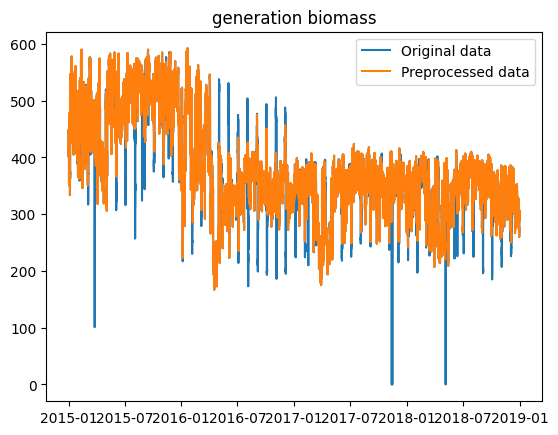

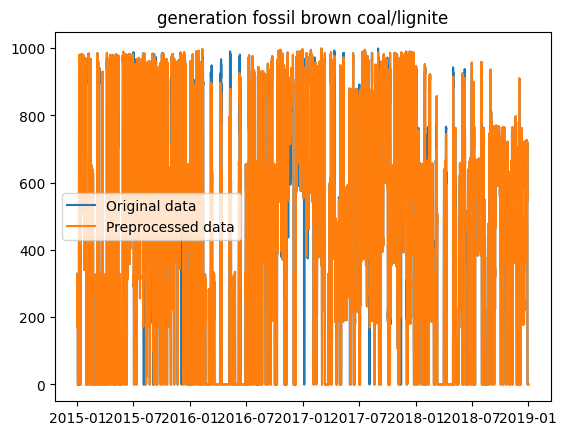

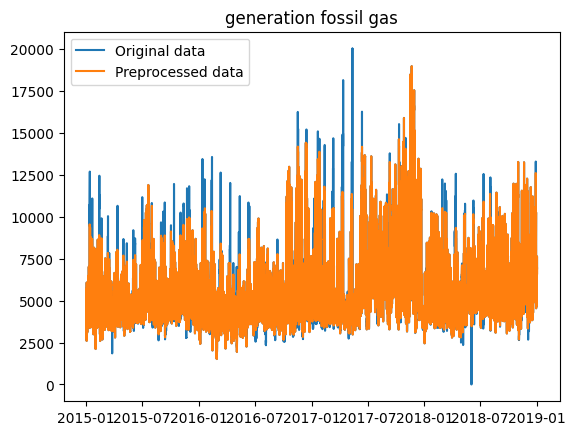

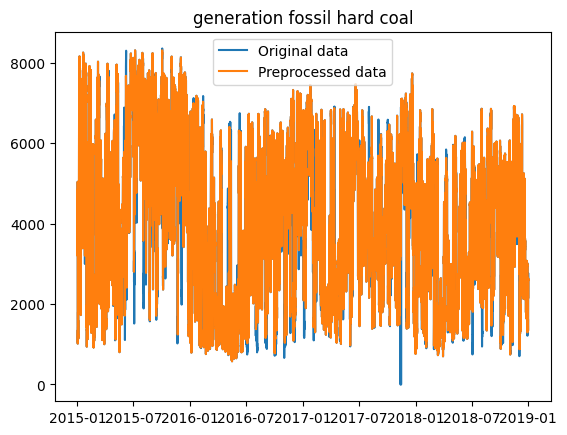

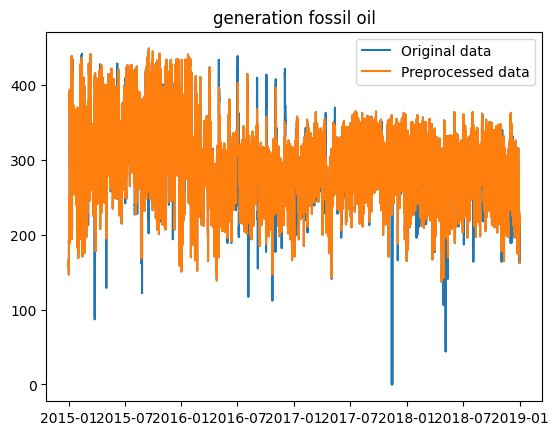

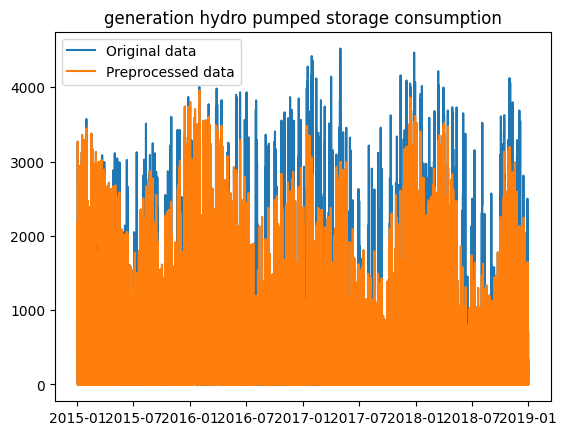

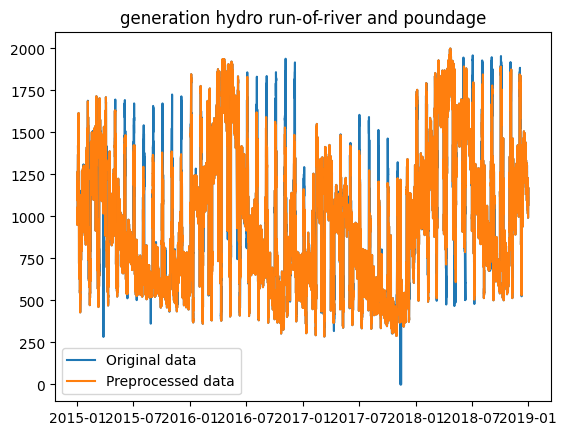

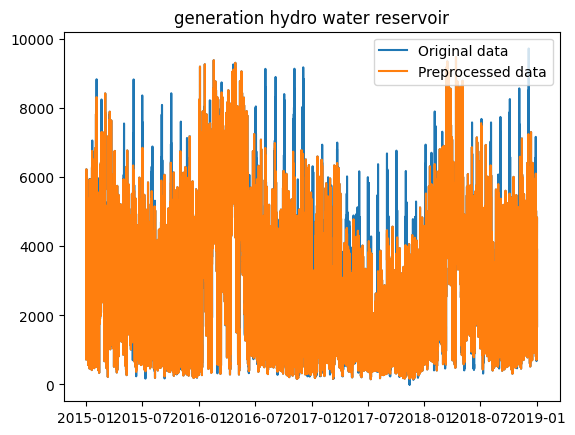

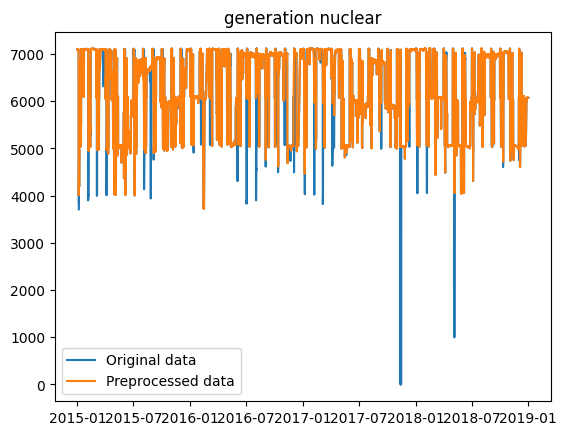

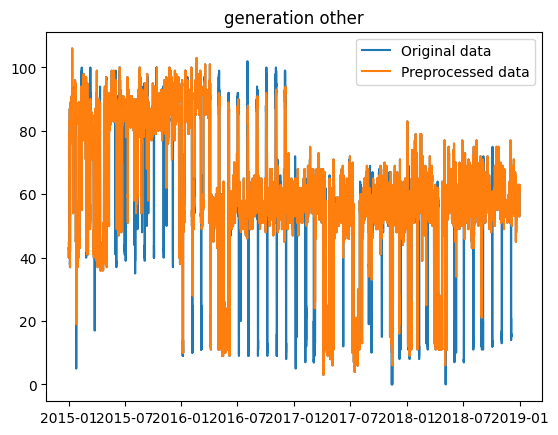

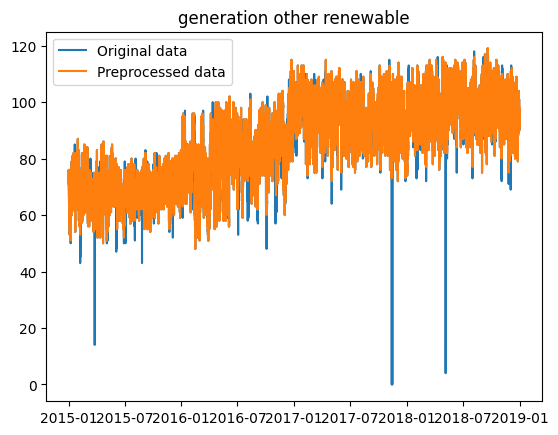

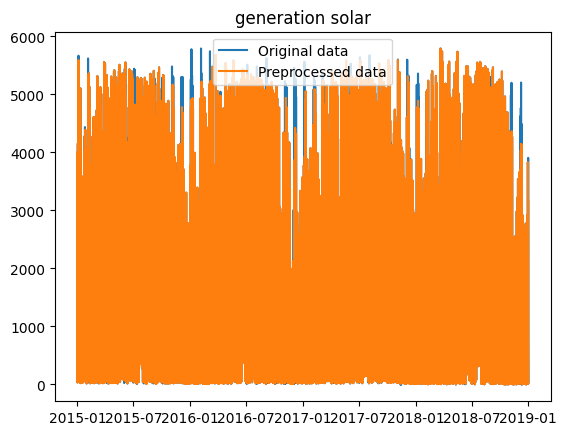

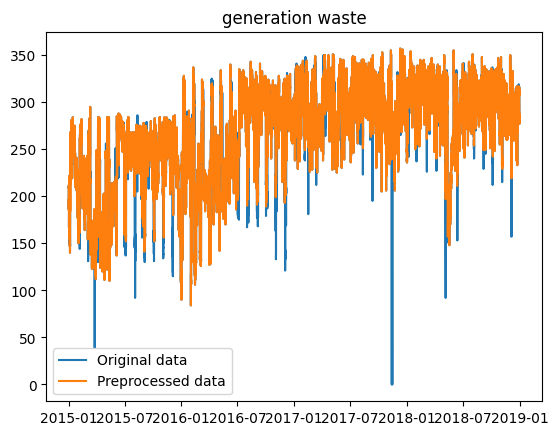

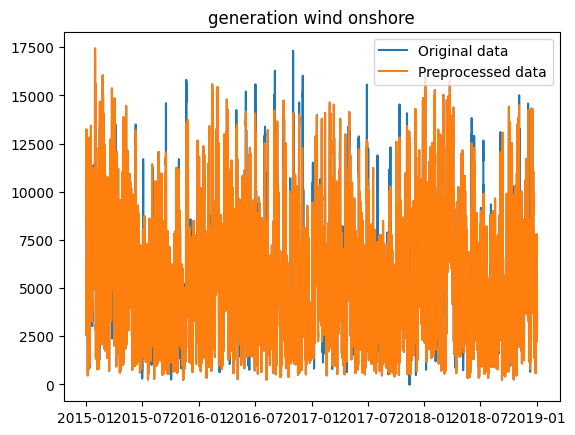

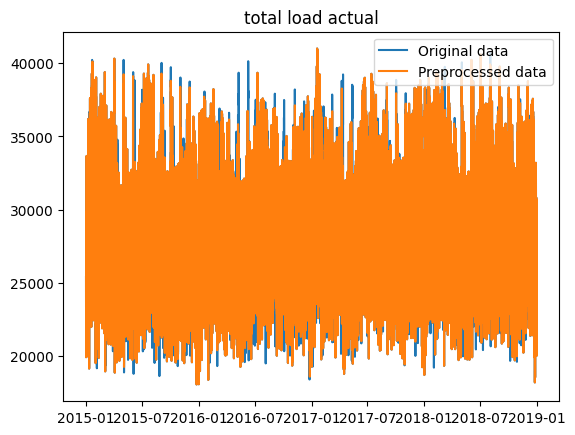

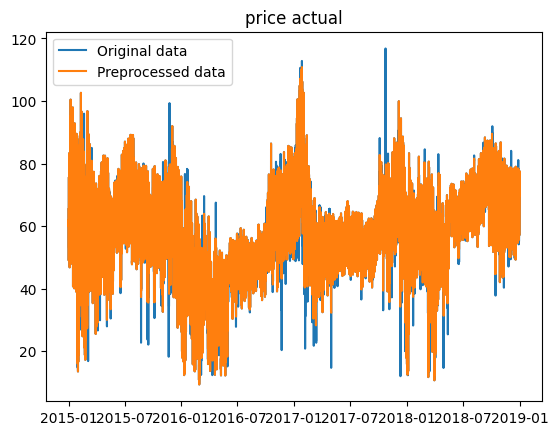

In [24]:
for column_name in column_names[1:]:
    plt.plot(energy_df['time'], energy_df[column_name], label='Original data')
    plt.plot(preprocessed_df['time'], preprocessed_df[column_name], label='Preprocessed data')
    plt.title(column_name)
    plt.legend()
    plt.show()

### Save to CSV

In [25]:
preprocessed_df.to_csv('data/preprocessed_dataset.csv', index=False)